In [1]:
from keras import regularizers
from keras.applications import DenseNet121
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import GlobalAveragePooling2D, Input

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.optimizers import Adam
from tensorflow.keras.metrics import *
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder

from PIL import Image
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import cv2 
import os
import ast

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
movies_train = pd.read_csv('/kaggle/input/imdb-dataset/output/movies_train_update.DAT', engine='python',
                         sep=',', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False)
movies_test = pd.read_csv('/kaggle/input/imdb-dataset/output/movies_test_update.DAT', engine='python',
                         sep=',', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False)
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

In [3]:
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
for genre in genres:
    movies_train[genre] = movies_train['genre'].apply(lambda x: 1 if genre in x else 0)
    movies_test[genre] = movies_test['genre'].apply(lambda x: 1 if genre in x else 0)

In [4]:
movies_test

,movieid,title,genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2989,For Your Eyes Only (1981),[Action],1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,1286,Somewhere in Time (1980),"[Drama, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
647,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648,3255,"League of Their Own, A (1992)","[Comedy, Drama]",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
649,974,Algiers (1938),"[Drama, Romance]",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
movies_train


,movieid,title,genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1650,Washington Square (1997),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3204,"Boys from Brazil, The (1978)",[Thriller],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2382,Police Academy 5: Assignment: Miami Beach (1988),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,2921,High Plains Drifter (1972),[Western],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2589,502,"Next Karate Kid, The (1994)","[Action, Children's]",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2590,2539,Analyze This (1999),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2591,3038,"Face in the Crowd, A (1957)",[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
genre_df = pd.DataFrame(movies_train['genre'].explode())
count_genre = genre_df['genre'].value_counts()
count_genre

genre
Drama          1003
Comedy          832
Action          384
Thriller        347
Romance         345
Horror          244
Adventure       223
Sci-Fi          218
Children's      195
Crime           159
War             110
Musical          96
Animation        82
Mystery          79
Fantasy          58
Documentary      51
Western          51
Film-Noir        34
Name: count, dtype: int64

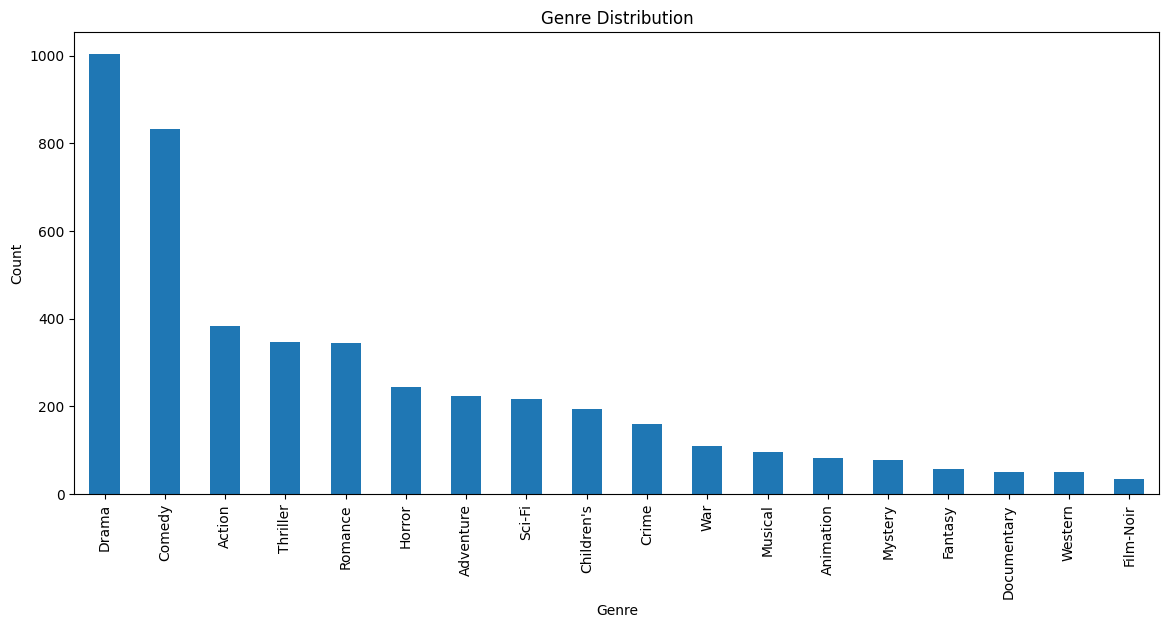

In [7]:
plt.figure(figsize=(12, 6))
count_genre.plot(kind= 'bar', figsize= (14, 6))
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

In [8]:
SIZE = 200
sources_dir = '/kaggle/input/imdb-dataset/output/ml1m-images/'
def preprocessing(data):
  X_dataset = []
  for i in tqdm(range(data.shape[0])):
    img = image.load_img(sources_dir +str(data['movieid'][i])+'.jpg', target_size=(SIZE,SIZE,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
  X = np.array(X_dataset)
  mlb = MultiLabelBinarizer()
  mlb.fit(data['genre'])
  # transform target variable
  y = mlb.transform(data['genre'])
  return X, y

In [9]:
x_train, y_train = preprocessing(movies_train)
x_test, y_test = preprocessing(movies_test)

100%|██████████| 651/651 [00:05<00:00, 118.17it/s]


In [10]:
import keras.backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
def basemodel(num_classes, mode, learning_rate):
    base_model = DenseNet121(weights = '/kaggle/input/densenet121-weight/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False, input_shape=(SIZE, SIZE, 3))
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(32, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    # Add a logistic layer for the 18 classes
    predictions = Dense(num_classes, activation='sigmoid')(x)  # Sigmoid activation for multilabel classification
    # Model to be trained
    model = Model(inputs=base_model.input, outputs=predictions)
    # Đóng băng các layer của base model
    for layer in base_model.layers:
        layer.trainable = mode
    model.compile(optimizer=Adam(lr = learning_rate), loss='binary_crossentropy', 
                  metrics=[f1_m,precision_m, recall_m])
    return model

In [12]:
def mode(mode):
    if mode == 0:
        model = basemodel(18, False, 0.001)
    elif mode == 1:
        model = basemodel(18, True, 0.00001)
    return model
# model.summary()

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('/kaggle/working/best_weights_32.h5', 
                         monitor='val_f1_m', verbose=1, save_best_only=True, 
                         mode='max', save_weights_only=True)

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 0.1317 - f1_m: 0.7136 - precision_m: 0.8322 - recall_m: 0.6267
Epoch 1: val_f1_m improved from -inf to 0.36283, saving model to /kaggle/working/best_weights_32.h5
41/41 [==============================] - 30s 349ms/step - loss: 0.1317 - f1_m: 0.7136 - precision_m: 0.8322 - recall_m: 0.6267 - val_loss: 0.3371 - val_f1_m: 0.3628 - val_precision_m: 0.5359 - val_recall_m: 0.2759
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.1314 - f1_m: 0.7074 - precision_m: 0.8224 - recall_m: 0.6223
Epoch 2: val_f1_m did not improve from 0.36283
41/41 [==============================] - 7s 172ms/step - loss: 0.1314 - f1_m: 0.7074 - precision_m: 0.8224 - recall_m: 0.6223 - val_loss: 0.3515 - val_f1_m: 0.3614 - val_precision_m: 0.5275 - val_recall_m: 0.2761
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.1321 - f1_m: 0.7022 - precision_m: 0.8288 - recall_m: 0.6109
Epoch 3: val_f1_m did not improve

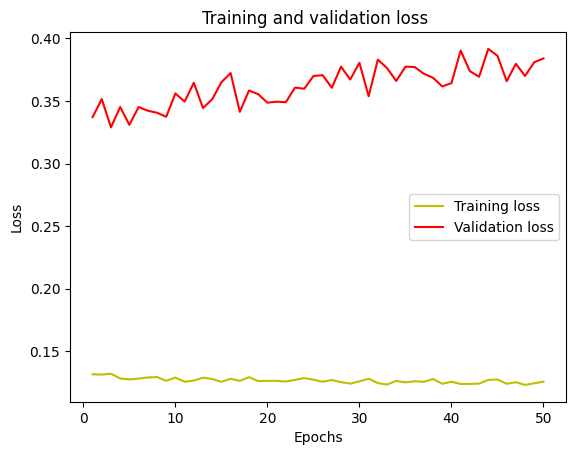

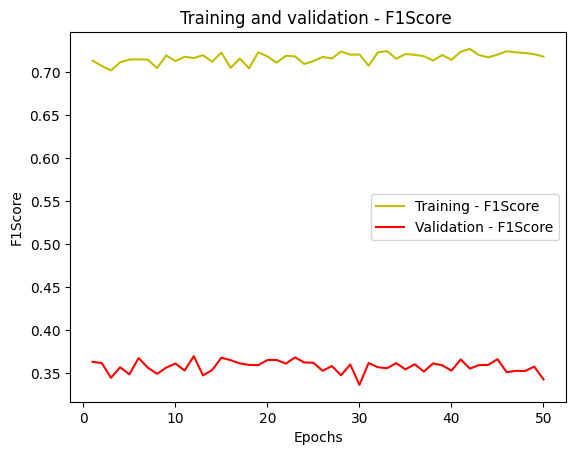

In [14]:
file_path = '/kaggle/input/dataweight/best_weights_32.h5'
model = mode(0)
if os.path.exists(file_path):
    model.load_weights(file_path)

history = model.fit(x_train, y_train,verbose = 1, epochs=50, validation_data=(x_test, y_test),
                    batch_size = 64, callbacks=[mc, es])

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'Training and validation loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

plt.plot(epochs, f1, 'y', label='Training - F1Score')
plt.plot(epochs, val_f1, 'r', label='Validation - F1Score')
plt.title(f'Training and validation - F1Score ')
plt.xlabel('Epochs')
plt.ylabel('F1Score')
plt.legend()
plt.show()

In [15]:
predictions = model.predict(x_test)
sorted_prediction_ids = np.argsort(-predictions, axis=1)

21/21 [==============================] - 6s 70ms/step


In [16]:
enc = OrdinalEncoder()
enc.fit_transform(genre_df[['genre']])

array([[ 7.],
       [14.],
       [15.],
       ...,
       [ 3.],
       [ 8.],
       [14.]])

In [17]:
vectors_labels_test = movies_test.drop(columns = ['movieid', 'title', 'genre'], axis = 1)

In [18]:
def get_column_names(row):
    return list(vectors_labels_test.columns[row == 1])
vectors_labels_test_new=vectors_labels_test.apply(get_column_names,axis=1).tolist()

In [19]:
top_5_prediction_ids = sorted_prediction_ids[:,:5]
original_shape = top_5_prediction_ids.shape
top_5_predictions = enc.inverse_transform(top_5_prediction_ids.reshape(-1, 1))
top_5_predictions = top_5_predictions.reshape(original_shape)
top_5_predictions[:10] # Spot check our first 10 values

array([["Children's", 'Comedy', 'Adventure', 'Fantasy', 'Musical'],
       ['Comedy', 'Drama', 'Romance', 'War', 'Musical'],
       ['Horror', 'Sci-Fi', 'Drama', 'Comedy', 'Thriller'],
       ['Comedy', 'Musical', 'Drama', 'Western', 'Romance'],
       ['Comedy', 'Drama', 'Western', 'Musical', 'Romance'],
       ['Drama', 'Thriller', 'Mystery', 'Crime', 'War'],
       ['Drama', 'Thriller', 'Crime', 'Mystery', 'War'],
       ['Drama', 'Romance', 'War', 'Comedy', 'Crime'],
       ["Children's", 'Comedy', 'Musical', 'Drama', 'Animation'],
       ['Comedy', 'Drama', 'Crime', 'Sci-Fi', 'War']], dtype=object)

In [20]:
def apk(actual, predicted, k):
    if len(predicted)>k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [21]:
mapk(vectors_labels_test_new,top_5_predictions,k = 5)

0.520726659839563

['Action', 'War']


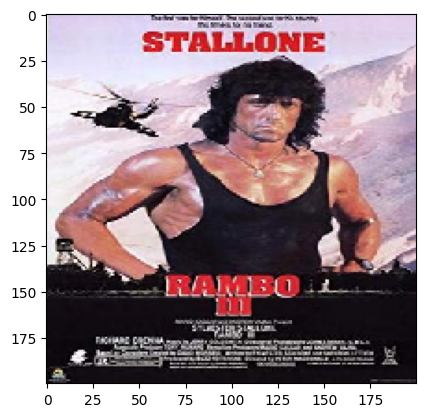

In [22]:
import random

i = random.randint(0, 650)

index = movies_test['movieid'][i]
img = image.load_img(f'/kaggle/input/imdb-dataset/output/ml1m-images/{index}.jpg', target_size=(SIZE,SIZE,3))

img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
print(movies_test['genre'][i])

1/1 [==============================] - 0s 31ms/step
Comedy (0.766)
Romance (0.32)
Drama (0.273)
War (0.0161)
Musical (0.0101)


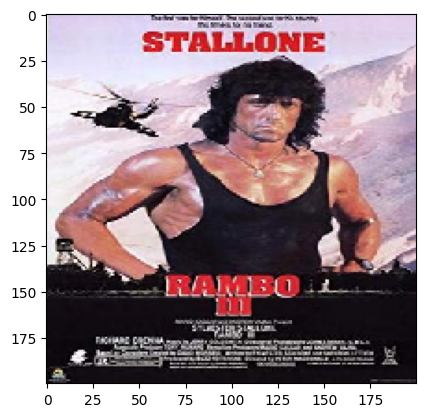

In [24]:
#%%
proba = model.predict(img.reshape(1,SIZE,SIZE,3))
top_5 = np.argsort(proba[0])[:-11:-1]
for i in range(5):
    print("{}".format(genres[top_5[i]])+" ({:.3})".format(proba[0][top_5[i]]))
plt.imshow(img)
#%%